# Preamble

This notebook shows the results of training with different data ranges. Due to past findings the prediction of the ai can be signifcantly better when trained on specific parts of the dataset. Here the ai has been trained on data within the range (distance) of 250 to the midpoint. 

# Preparation of data

## Setting up dataframe

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from typing import List
import os 
import sklearn.preprocessing

In [2]:
distance_threshold = 250
HEIGHT_CONSTANT = False
directory_path = '/Users/benedictkunzmann/Desktop/Bachelorarbeit/Verlauf/Modelle/20230902_version_3.1/01_measurement_data'

In [3]:
### function definition section:
def sort_key(file_path): # define a custom sorting key function to sort filenames alphabetically
    """ notes here """
    
    file_name = os.path.basename(file_path)
    
    return file_name

def get_csv_paths_list(directory_path: str):
    """ notes:
        this function is meant to list all A4T-, A5T-, A6T- and A7T-measurement files
         for different coil-coil-distances in form of her absolute filepathes."""

    csv_files = []

    parPath = os.getcwd()
    dataFolder = directory_path
    dataPath = os.path.join(parPath, dataFolder)

    subfolders = [f.path for f in os.scandir(dataPath) if f.is_dir()]

    for folder in subfolders:
        files_in_dir = glob.glob(os.path.join(folder, "*.csv"))
        sorted_files = sorted(files_in_dir, key=sort_key)
        csv_files.append(sorted_files)

    csv_files = csv_files[0:-1]

    return csv_files

def process_csv_files(csv_block: List[str]) -> pd.DataFrame:
    """ notes:
        parameter csv_block needs to be a list of 4 filepath strings.
        those strings refer to 4 different measurement files of sensors
         A4T, A5T, A6T and A7T.
        for a different height (coil-coil-distance) another csv_block
         has to be passed in.
        this function returns a combined/merged pd.dataframe in which
         the structure is ["A4T","A5T","A6T","A7T","x","y","z"], 
         thus all XxY-grids within each individual measurment file
         are flattened."""

    tmp_dfs = []
    columns = ["A4T","A5T","A6T","A7T","x","y","z"]
    merged_df = pd.DataFrame(columns=columns)

    curr_dz = float(csv_block[0].split("_dz")[1].split("/")[0]) # extract current z-height of dataset
    for _, sensor_file in enumerate(csv_block):
        data_list = [] # create a list to store the data

        curr_sensor = sensor_file.split("_")[-1].split(".")[0]  # extract current sensor's name in dataset

        df = pd.read_csv(sensor_file,skiprows=28,sep=",",index_col=0)
        df.index = pd.to_numeric(df.index)
        df.columns = pd.to_numeric(df.columns)

        for row_label, row in df.iterrows():
            for col_label, value in row.items():
                data_list.append((value, col_label, row_label, curr_dz, curr_sensor))

        tmp_dfs.append(pd.DataFrame(data_list, columns=["data","x","y","z","sensor"]))

        for _, tmp_df in enumerate(tmp_dfs):
            sensor_name = tmp_df["sensor"][0]
            merged_df[sensor_name] = tmp_df["data"]
        merged_df["x"] = tmp_df["x"]
        merged_df["y"] = tmp_df["y"]
        merged_df["z"] = tmp_df["z"]
        
    return merged_df

In [4]:
def extend_array(arr: np.ndarray, n: int):
    if arr.ndim == 1:
        result = []
        result.extend([arr[0]])
        for i in range(1, len(arr)):
            diff = (arr[i] - arr[i-1]) / (n+1)
            new_elements = [arr[i-1] + j*diff for j in range(1, (n+1))]
            result.extend(new_elements)
            result.extend([arr[i]])
        return np.array(result)

    result = []
    for row in arr:
        new_row = [row[0]]
        for i in range(1, len(row)):
            diff = (row[i] - row[i-1]) / (n+1)
            new_elements = [row[i-1] + j*diff for j in range(1, (n+1))]
            new_row.extend(new_elements)
            new_row.append(row[i])
        result.append(new_row)
    return np.array(result)

In [5]:
csv_files = []
merged_df_list = []

csv_files = get_csv_paths_list(directory_path) # function call to get the filepathes of all measurement files
csv_files # jupyter print

for idx, z_height_group in enumerate(csv_files): # loop through each group of files (A4T, A5T, A6T, A7T)
    merged_df_list.append(process_csv_files(z_height_group))

final_combined_df = pd.concat(merged_df_list, ignore_index=True)
final_combined_df

,A4T,A5T,A6T,A7T,x,y,z
0,0.122,0.159,0.161,0.148,620.0,-1120.0,190.0
1,0.160,0.194,0.192,0.173,600.0,-1120.0,190.0
2,0.145,0.186,0.189,0.178,580.0,-1120.0,190.0
3,0.132,0.167,0.168,0.154,560.0,-1120.0,190.0
4,0.132,0.167,0.172,0.161,540.0,-1120.0,190.0
...,...,...,...,...,...,...,...
49828,0.143,0.179,0.176,0.156,-540.0,1120.0,180.0
49829,0.110,0.151,0.143,0.128,-560.0,1120.0,180.0
49830,0.114,0.159,0.156,0.143,-580.0,1120.0,180.0
49831,0.157,0.192,0.187,0.167,-600.0,1120.0,180.0


In [6]:
final_combined_df["A4T"].max()

3.934

### Cuttting the Frame

In [7]:
# Calculate Euclidean distance
final_combined_df['distance'] = np.sqrt(final_combined_df['x']**2 + final_combined_df['y']**2)

# Filter the DataFrame based on the distance threshold
filtered_df = final_combined_df[final_combined_df['distance'] <= distance_threshold]

# Drop the 'distance' column if you don't need it anymore
filtered_df = filtered_df.drop(columns=['distance'])

# Display the filtered DataFrame
filtered_df

,A4T,A5T,A6T,A7T,x,y,z
2800,1.981,1.104,1.171,1.190,60.0,-240.0,190.0
2801,2.104,1.110,1.172,1.122,40.0,-240.0,190.0
2802,2.173,1.113,1.165,1.067,20.0,-240.0,190.0
2803,2.207,1.100,1.152,1.024,0.0,-240.0,190.0
2804,2.227,1.077,1.124,1.002,-20.0,-240.0,190.0
...,...,...,...,...,...,...,...
47028,1.212,1.067,2.157,1.317,20.0,240.0,180.0
47029,1.226,1.093,2.141,1.326,0.0,240.0,180.0
47030,1.226,1.133,2.092,1.338,-20.0,240.0,180.0
47031,1.210,1.176,2.007,1.337,-40.0,240.0,180.0


In [8]:
# input_data = final_combined_df[["A4T", "A5T", "A6T", "A7T"]]
input_data = filtered_df[["A4T", "A5T", "A6T", "A7T"]]
input_data

,A4T,A5T,A6T,A7T
2800,1.981,1.104,1.171,1.190
2801,2.104,1.110,1.172,1.122
2802,2.173,1.113,1.165,1.067
2803,2.207,1.100,1.152,1.024
2804,2.227,1.077,1.124,1.002
...,...,...,...,...
47028,1.212,1.067,2.157,1.317
47029,1.226,1.093,2.141,1.326
47030,1.226,1.133,2.092,1.338
47031,1.210,1.176,2.007,1.337


In [9]:
# target_data = final_combined_df[["x", "y"]]
target_data = filtered_df[["x", "y"]]
target_data

,x,y
2800,60.0,-240.0
2801,40.0,-240.0
2802,20.0,-240.0
2803,0.0,-240.0
2804,-20.0,-240.0
...,...,...
47028,20.0,240.0
47029,0.0,240.0
47030,-20.0,240.0
47031,-40.0,240.0


## Scale the dataframe

In [10]:
scaler_input = sklearn.preprocessing.MinMaxScaler()
scaled_input_data = scaler_input.fit_transform(input_data)
scaled_input_data.max(axis=0)

array([1., 1., 1., 1.])

In [11]:
scaler_target = sklearn.preprocessing.MinMaxScaler()
scaled_target_data = scaler_target.fit_transform(target_data)
scaled_target_data.max(axis=0)

array([1., 1.])

## Get distribution of the datapoints

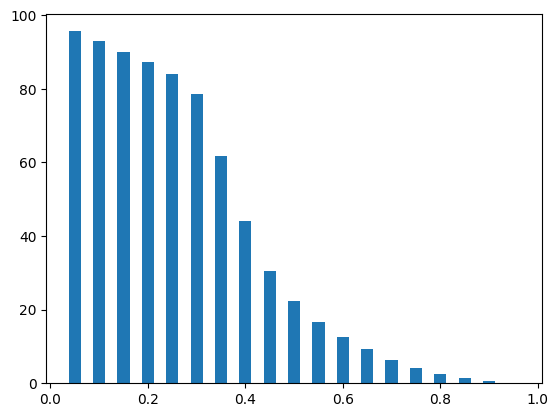

In [12]:
import matplotlib.pyplot as plt

percentages = []
thresholds = []

for threshold in np.arange(0.05, 1, 0.05):
    thresholds.append(threshold)
    filtered_arr = scaled_input_data[scaled_input_data >= threshold]
    percentage = len(filtered_arr) / scaled_input_data.size * 100
    percentages.append(percentage)
    # print(f"Threshold: {threshold:.2f}, Percentage: {percentage:.2f}%")

plt.bar(thresholds, percentages, width= 0.025)
plt.show()

# Model

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Input, Activation, Dense
from keras.initializers import HeUniform
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [14]:
import metrics
import datetime
import time

## Generating training and testing data

In [15]:
input_tensor = tf.convert_to_tensor(scaled_input_data)
target_tensor = tf.convert_to_tensor(scaled_target_data)
n_features = 4

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-29 11:12:05.383522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-29 11:12:05.383806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Create a dataset with the input and target tensors
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor))

# Shuffle the dataset with a buffer size of the number of samples
buffer_size = input_tensor.shape[0]
shuffled_dataset = dataset.shuffle(buffer_size)

# Extract the shuffled input and target tensors from the shuffled dataset
input_tensor, target_tensor = next(iter(shuffled_dataset.batch(buffer_size)))

input_dataset = tf.data.Dataset.from_tensor_slices(input_data)
target_dataset = tf.data.Dataset.from_tensor_slices(target_tensor)

print(input_tensor.shape)

(3423, 4)


In [17]:
buffer_size = input_tensor.shape[0]
indices = np.arange(buffer_size)
np.random.shuffle(indices)

# Define the sizes for training, validation, and test sets
train_size = int(0.7 * buffer_size)  # 70% of data for training
val_size = int(0.15 * buffer_size)   # 15% of data for validation
test_size = buffer_size - train_size - val_size  # Rest for testing

# Split the shuffled indices into training, validation, and test sets
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Convert the indices to TensorFlow tensors
train_indices = tf.convert_to_tensor(train_indices, dtype=tf.int32)
val_indices = tf.convert_to_tensor(val_indices, dtype=tf.int32)
test_indices = tf.convert_to_tensor(test_indices, dtype=tf.int32)

# Use the indices to create tensors for training, validation, and test sets
train_data = tf.gather(input_tensor, train_indices)
train_labels = tf.gather(target_tensor, train_indices)

val_data = tf.gather(input_tensor, val_indices)
val_labels = tf.gather(target_tensor, val_indices)

test_data = tf.gather(input_tensor, test_indices)
test_labels = tf.gather(target_tensor, test_indices)


## Generating weights for training


In [18]:
train_labels_np = train_labels.numpy()
diff_from_1 = np.abs(1 - train_labels)
output_weights = 1 / (diff_from_1 + 1e-7) # 1e-7 to prevent "devided by zero error"
# sample_weight_train /= np.sum(sample_weight_train) / len(sample_weight_train)

diff_from_1, output_weights

(array([[0.58333333, 0.20833333],
        [0.25      , 0.25      ],
        [0.95833333, 0.5       ],
        ...,
        [0.70833333, 0.41666667],
        [0.16666667, 0.375     ],
        [0.83333333, 0.66666667]]),
 array([[1.71428542, 4.7999977 ],
        [3.9999984 , 3.9999984 ],
        [1.04347815, 1.9999996 ],
        ...,
        [1.41176451, 2.39999942],
        [5.9999964 , 2.66666596],
        [1.19999986, 1.49999978]]))

## Building the model

In [29]:
n_hidden = 2048

model = Sequential()
model.add(Input(shape= (n_features), name='Dense_Input'))
# model.add(Dense(n_hidden/2, kernel_initializer= HeUniform(), name='Dense_1'))
model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_1'))
model.add(Activation('relu', name='relu_1'))
model.add(Dropout(rate=0.2, name='dropout_1'))
model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_2'))
model.add(Activation('relu', name='relu_2'))
model.add(Dropout(rate=0.2, name='dropout_2'))
# model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_3'))
# model.add(Activation('relu', name='relu_3'))
# model.add(Dropout(rate=0.2, name='dropout_3'))
# model.add(Dense(n_hidden/2, kernel_initializer= HeUniform(), name='Dense_4'))
model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_4'))
model.add(Activation('relu', name='relu_4'))
model.add(Dense(2, name='Dense_Out'))
model.add(Activation('sigmoid', name='sigmoid_Out'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 2048)              10240     
                                                                 
 relu_1 (Activation)         (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 Dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 relu_2 (Activation)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 Dense_4 (Dense)             (None, 2048)             

## Training the model

In [31]:
import math
# Define configuration parameters
start_lr = 0.0001
rampup_epochs = 40
exp_decay = 0.01

# Define the scheduling function
def scheduler(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

In [32]:
optimizer = Adam()
loss = MeanSquaredError()

timestamp = time.time()
datetime_obj = datetime.datetime.fromtimestamp(timestamp)
# Format the datetime object as a string in your desired format
readable_time = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')

mcp_save = ModelCheckpoint(f'MLP-DataRange_{distance_threshold}_weighted_{readable_time}.h5', 
                           save_best_only=True,
                           monitor='val_mse', 
                           mode='min')

learning_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer=optimizer, 
                loss="mse",
                loss_weights= output_weights,
                metrics=["mse", metrics.CenterMeanXYNormRealWorld(scaler=scaler_target),
                                metrics.MeanXYNormRealWorld(scaler=scaler_target),
                                metrics.MeanXYSquarredErrorRealWorld(scaler=scaler_target),  
                                metrics.MeanXYAbsoluteErrorRealWorld(scaler=scaler_target),
                                metrics.MeanXYRootSquarredErrorRealWorld(scaler=scaler_target)]
)

In [33]:
history = model.fit(
    x = train_data,
    y = train_labels, 
    epochs = 250,
    validation_data = [val_data, val_labels],
    callbacks = [learning_callback]
)

Epoch 1/250


2023-09-29 11:58:13.228502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2048xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2048xi1

 3/75 [>.............................] - ETA: 4s - loss: 13218.1104 - mse: 0.0931 - centernormXYReal: 178.7392 - normXYReal: 188.7435 - mseXYReal: 21460.9805 - maeXYReal: 121.6967 - rmseXYReal: 146.4957

KeyboardInterrupt: 

## Analysis of the model

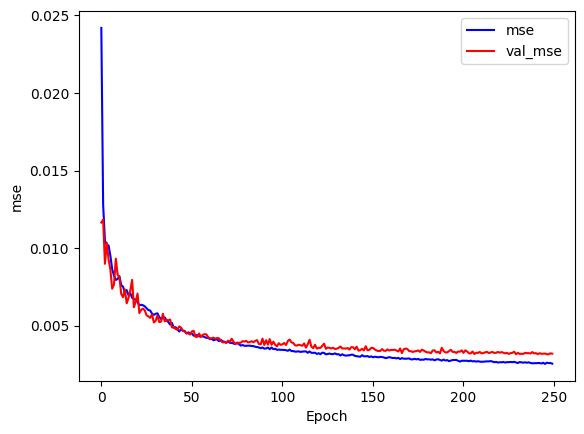

In [24]:
plt.plot(history.history["mse"], 'b', label="mse")
plt.plot(history.history["val_mse"], 'r', label="val_mse")
plt.ylabel("mse")
plt.xlabel("Epoch")
plt.legend()
plt.show()

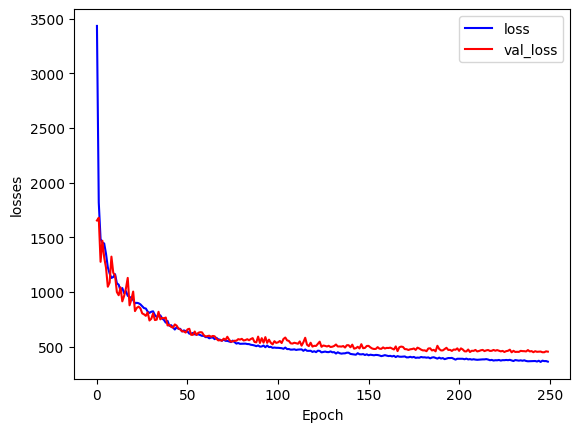

In [25]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.ylabel("losses")
plt.xlabel("Epoch")
plt.legend()
plt.show()

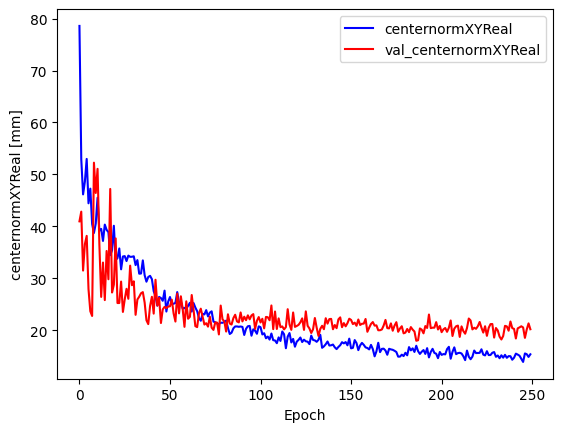

In [26]:
plt.plot(history.history["centernormXYReal"], 'b', label="centernormXYReal")
plt.plot(history.history["val_centernormXYReal"], 'r', label="val_centernormXYReal")
plt.ylabel("centernormXYReal [mm]")
plt.xlabel("Epoch")
plt.legend()
plt.show()

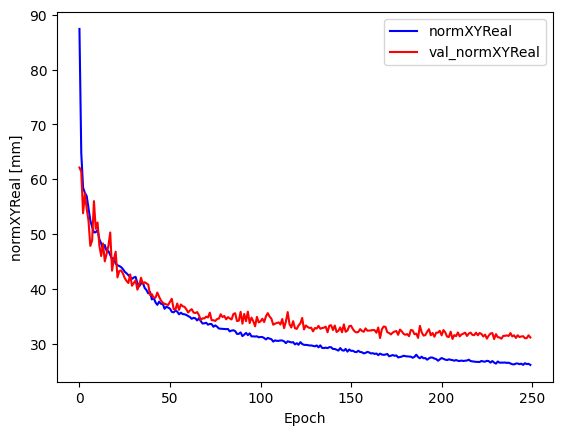

In [27]:
plt.plot(history.history["normXYReal"], 'b', label="normXYReal")
plt.plot(history.history["val_normXYReal"], 'r', label="val_normXYReal")
plt.ylabel("normXYReal [mm]")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [28]:
results = model.evaluate(test_data, test_labels)
dict(zip(model.metrics_names, results))

17/17 [==============================] - 2s 95ms/step - loss: 408.2276 - mse: 0.0029 - centernormXYReal: 20.4998 - normXYReal: 29.5846 - mseXYReal: 662.8002 - maeXYReal: 18.5154 - rmseXYReal: 25.7449


{'loss': 408.2276306152344,
 'mse': 0.002876736456528306,
 'centernormXYReal': 20.499797821044922,
 'normXYReal': 29.584571838378906,
 'mseXYReal': 662.8001708984375,
 'maeXYReal': 18.515399932861328,
 'rmseXYReal': 25.744905471801758}